In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
sys.path.append('..')

from sbi import simulator, model

Could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


```python -m sbi.train --trainfrom=file --savepath test_weights/test --datapath data --max_epochs=50```

In [2]:
theta_samples, x_samples = simulator.load(path = '../data', dataloader = False)

sim = simulator.Simulator()
#sim(n_train = 50_000, outpath='../data')
plx, e_plx, distance = sim.plxdata[:,0], sim.plxdata[:,1], sim.plxdata[:,2]

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
max(distance)

842.8234252929688

In [4]:
def log_prior(dist):
    L = 350
    if (1 < dist < 2000):
        return np.log(dist**2 / (2*L**3)) - dist / L
    else:
        return np.inf

def log_likelihood(dist, plx, e_plx, prior = True):
    likelihood = -0.5*(np.log(e_plx) + ((1000/dist) - plx)**2/e_plx)
    prior = -log_prior(dist)
    return likelihood + prior if prior else likelihood

100%|██████████| 5000/5000 [00:05<00:00, 875.75it/s] 


256.21685791015625 258.214344154622


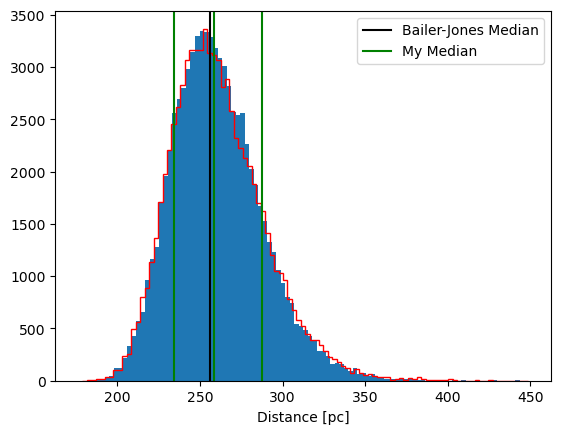

In [5]:
import emcee
import corner

i = np.random.randint(0, len(distance))

# Sampling with `emcee`
ndim, nwalkers = 1, 16
sampler_prior = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(plx[i], e_plx[i], True))
# Initialize the walkers
theta_guess = np.random.uniform(low=(1), high=(2000), size=(nwalkers, ndim))
pos = theta_guess + np.random.randn(nwalkers, ndim)
sampler_prior.run_mcmc(pos, 5000, progress=True);

# Sampling with `emcee`
ndim, nwalkers = 1, 16
sampler_naive = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(plx[i], e_plx[i], False))
# Initialize the walkers
theta_guess = np.random.uniform(low=(1), high=(2000), size=(nwalkers, ndim))
pos = theta_guess + np.random.randn(nwalkers, ndim)
sampler_naive.run_mcmc(pos, 5000, progress=True);

chain_prior=sampler_prior.get_chain(flat=True)
plt.hist(chain_prior[1000:], bins = 100)
chain_naive=sampler_naive.get_chain(flat=True)
plt.hist(chain_naive[1000:], bins = 100, histtype='step', color='red')
plt.axvline(distance[i], label="Bailer-Jones Median", c = 'k')
plt.axvline(np.percentile(chain_prior, 50), label="My Median", c = 'green')
plt.axvline(np.percentile(chain_prior, 84), c = 'green')
plt.axvline(np.percentile(chain_prior, 16), c = 'green')
plt.xlabel('Distance [pc]')
plt.legend()
print(distance[i], np.median(chain_prior))

In [6]:
torch.mean(theta_samples, axis=0)

tensor([4.0948e+04, 2.0439e+02, 1.4474e-02])

In [7]:
import corner

theta_test = np.array([15000, 50, 0.012])
x_test = sim.forward_noisy(*theta_test)
x_test_norm = (torch.Tensor(x_test) - x_samples.mean(dim=0)) / x_samples.std(dim=0)

npereader = model.load_model_from_path('../test_weights/test')
context = npereader.featurizer(x_test_norm).unsqueeze(0)
samples_test = npereader.flow.sample(num_samples=10000, context=context) * theta_samples.std(dim=0) + theta_samples.mean(dim=0)

In [8]:
x_test

array([1.98728806e+01, 7.59755864e-02, 2.04196101e-16, 3.50631752e-16,
       9.32246173e-17, 6.22840021e-16, 4.50883626e-16, 2.03642847e-16,
       1.08853511e-16, 5.78852110e-17, 6.46545791e-19, 1.10321262e-18,
       2.94270076e-19, 1.97783700e-18, 1.42975090e-18, 6.44922307e-19,
       3.43227098e-19, 1.84416044e-19])

True parameters:
temperature = 15000.0 K 
distance = 50.0 pc 
radius = 0.012 r_sun


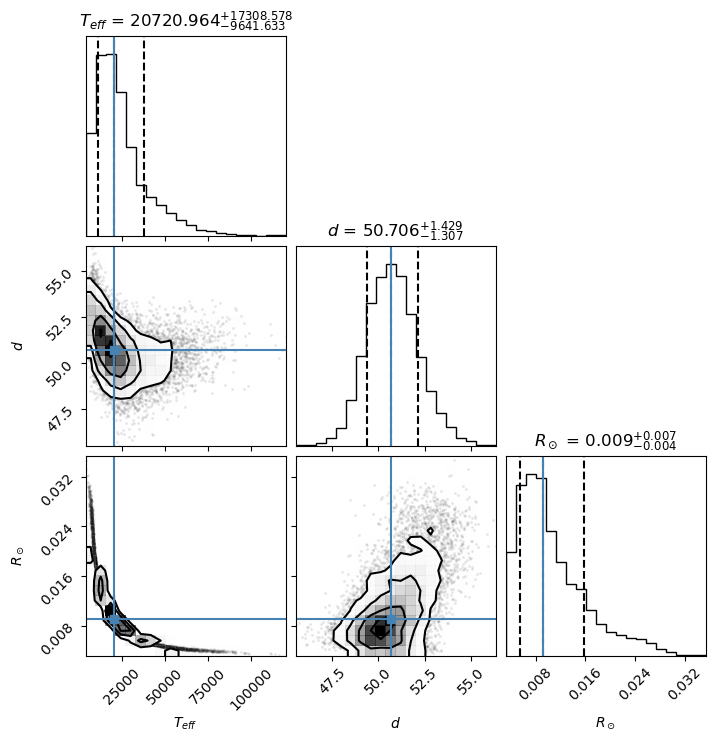

In [9]:
labels = [r"$T_{eff}$", r"$d$", r"$R_\odot$"]
best_est = np.zeros((len(labels)))
unc = []

temp_chain = samples_test[0].detach().numpy()
#temp_chain[:, 2] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

corner.corner(temp_chain, labels=labels, truths=best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12});
print(f"True parameters:\ntemperature = {theta_test[0]} K \ndistance = {theta_test[1]} pc \nradius = {theta_test[2]} r_sun")
plt.show()